<a href="https://colab.research.google.com/github/kumarrah2002/Fractal_Generator_GPU/blob/main/generator/juliaGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *GPU Acceleration for Julia Set Generation*
## **Import dependencies**

In [ ]:
#!pip install numba
import numba as nb
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# **Julia Fractal Generation**

In [ ]:
#x = Real Axis
#y = Imaginary Axis

width , height = 500, 500
xmin, xmax = -1.5, 1.5
xwidth = xmax - xmin
ymin, ymax = -1.5, 1.5
yheight = ymax - ymin
cx = 0
cy = -0.64
cy_incr = np.linspace(-0.59, -0.99, 41)

As discussed in the mandelbrotGeneration.ipynb file, Julia Sets occur at the boundary of bounded and infinite regions in Mandelbrot Sets. This is actually not a coincidence since both sets actually operate on the **same equation**!

The same calculations as Mandelbrot Sets are involved with Julia sets, but where Mandelbrot fractals iterate over c and keep z constant, Julia fractals iterate over c and keep z constant. This results in the stark differences in shapes between the two sets. 

First, we set our image panel to be 500 x 500 pixels. From there, we set our real axis and imaginary axis boundaries in the complex plane to be between -1.5 and 1.5. The total distance between these two points are calculated and stored into *xwidth* and *yheight*. 

*cx* and *cy* represent the complex coordinate of the *c* value. We set the c value to be 0 - 0.64j to create a beautiful Julia fractal. We will also create a GIF of the evolution of a Julia fractal across the imaginary axis. For this, an ndarray of numbers called *cy_incr* was created. This consists of values between -0.59 and -0.99 and increment by 0.01, hence creating an array of size 42. 

Julia Fractal created in 3.162422 sec. using CPU


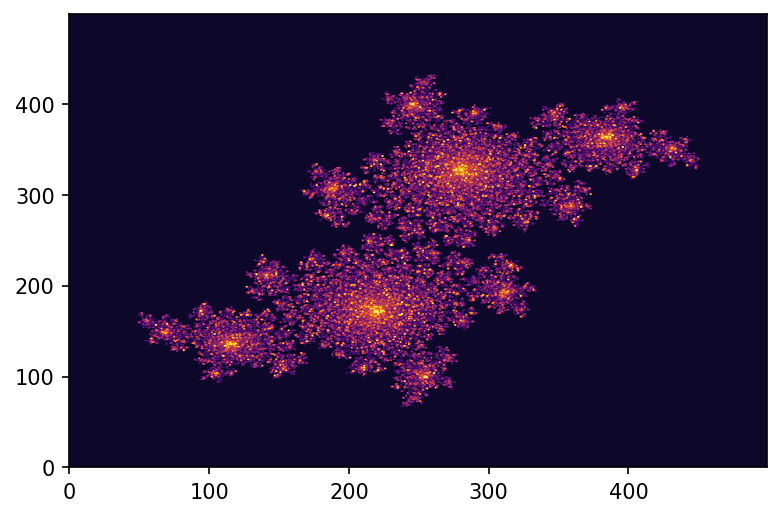

In [ ]:
def julia_fractal(x, y, array, cx, cy):
  max = 1000
  iter = 0
  c = complex(cx, cy)
  z = complex(x / width * xwidth + xmin,
              y / height * yheight + ymin)
  
  while(abs(z)) <= 10 and iter < max:
    z = z**2 + c
    iter += 1

  return iter / max

julia_cpu = np.zeros([width, height])

start_cpu = timer()
for x in range(width):
  for y in range(height):
    julia_cpu[x][y] = julia_fractal(x, y, julia_cpu, cx, cy)
      

end_cpu = timer() - start_cpu

plt.figure(dpi=150)
plt.contourf(julia_cpu.T, cmap='inferno')
print("Julia Fractal created in %f sec. using CPU" % end_cpu)


It only took a couple seconds to create the Julia fractal using the CPU. Thats pretty good!

Julia Fractal created in 0.432877 sec. using GPU


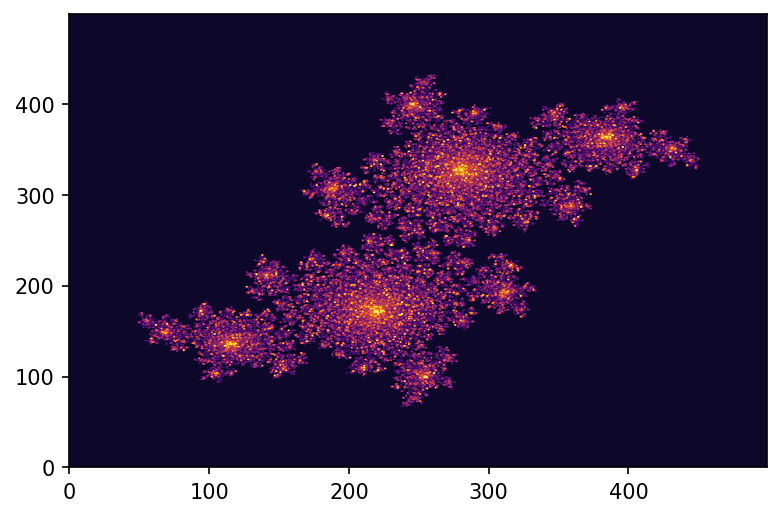

In [ ]:
@nb.njit(target_backend='cuda') 
def julia_fractal(x, y, array, cx, cy):
  max = 1000
  iter = 0
  c = complex(cx, cy)
  z = complex(x / width * xwidth + xmin,
              y / height * yheight + ymin)
  
  while(abs(z)) <= 10 and iter < max:
    z = z**2 + c
    iter += 1

  return iter / max

julia_gpu = np.zeros([width, height])

start_gpu = timer()
for x in range(width):
  for y in range(height):
    julia_gpu[x][y] = julia_fractal(x, y, julia_gpu, cx, cy)

end_gpu = timer() - start_gpu


plt.figure(dpi=150)
plt.contourf(julia_gpu.T, cmap='inferno')
print("Julia Fractal created in %f sec. using GPU" % end_gpu)

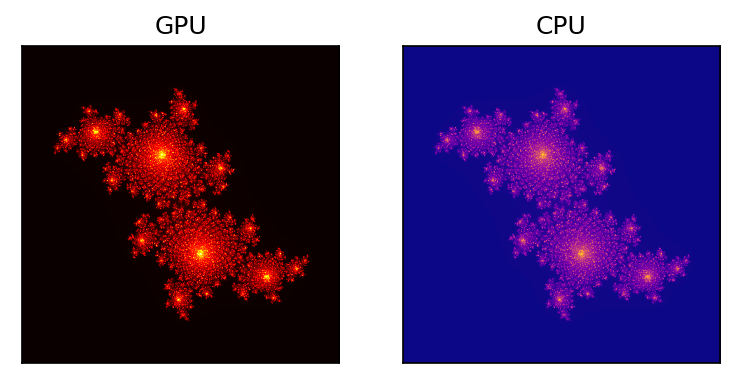

Julia Fractal created in 0.432877 sec. using GPU
Julia Fractal created in 3.162422 sec. using CPU
GPU is 7.305595x more powerful than using CPU for Julia Fractals


In [ ]:
plt.figure(dpi=150)
plt.subplot(121),plt.imshow(julia_gpu.T, cmap='hot'),plt.title('GPU')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(julia_cpu.T, cmap='plasma'),plt.title('CPU')
plt.xticks([]), plt.yticks([])
plt.show()

print("Julia Fractal created in %f sec. using GPU" % end_gpu)
print("Julia Fractal created in %f sec. using CPU" % end_cpu)
print("GPU is %fx more powerful than using CPU for Julia Fractals" % (end_cpu / end_gpu))

Once we add the Numba NJIT header and move the processes to the GPU, we get a time of less than a second! For the amount of detail seen in the photo, it is definitely awesome that we can create these fractals in less than a second. 

## **Now, we will create a Julia Fractal GIF!**

In [ ]:
!mkdir julia

mkdir: cannot create directory ‘julia’: File exists


A directory is created to store the Julia fractals at each value in the *cy_incr* array

Julia Fractal created in 36.618463 sec. using GPU


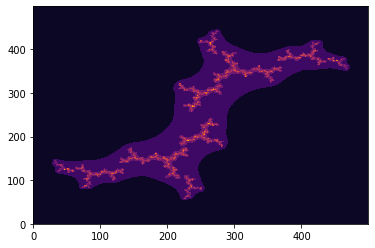

In [ ]:
@nb.njit(target_backend='cuda') 
def julia_fractal(x, y, array, cx, cy):
  max = 1000
  iter = 0
  c = complex(cx, cy)
  z = complex(x / width * xwidth + xmin,
              y / height * yheight + ymin)
  
  while(abs(z)) <= 10 and iter < max:
    z = z**2 + c
    iter += 1

  return iter / max

julia_gpu = np.zeros([width, height])

start_gpu = timer()
for cy in cy_incr:
  for x in range(width):
    for y in range(height):
      julia_gpu[x][y] = julia_fractal(x, y, julia_gpu, cx, cy)
  plt.contourf(julia_gpu.T, cmap='inferno')
  plt.savefig(f"julia/julia_{cy}.jpg")


end_gpu = timer() - start_gpu


plt.figure(dpi=150)
plt.contourf(julia_gpu.T, cmap='inferno')
print("Julia Fractal created in %f sec. using GPU" % end_gpu)


Here, we use the same code as the GPU process we executed above. Remember the *cy_incr* array? Now, we will iterator over each value of the array for a value of c and create a new fractal. These fractal images are saved in the julia folder we created above. Generating the 42 images only took 36 seconds to generate, thats less than one second per image!

Now, we will combine the images to create a GIF using the imageio library.

In [ ]:
import imageio

gif = [] 
# get the path/directory

files = [f"julia/julia_{cy}.jpg" for cy in cy_incr]

for image in files:
  gif.append(imageio.imread(image))
imageio.mimsave(f'julia/julia.gif', gif)

And voila! We have our julia fractal gif! Open the julia.gif file and you will be amazed at the result, especially at the fact that Python code created this in 30 seconds! (With the help of a GPU of course) 

Now it's your turn! Play around with the *cx* and *cy* values to create your own fractal! Make sure that the values stay between -1.5 and 1.5 so you don't get black-screened. 